In [1]:
%matplotlib inline
import os, sys, gc, argparse
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [2]:
dataDir = 'data/'
loadDir = '{0}/load'.format(dataDir)
saveDir = '{0}/save'.format(dataDir)

# In[3]:


#parser = argparse.ArgumentParser()
##parser.add_argument("-nc", type=int)
#args = parser.parse_args()
#print(args)
#nc = args.nc

fullGuesses = np.load('{0}/test_set_master_guess_array.npy'.format(loadDir), allow_pickle = True)
print(fullGuesses.shape)

(10000,)


In [3]:
def guesses_to_probs(guesses, numCats):
    guesses = np.int_(guesses)
    hist = np.bincount(guesses, minlength = numCats)
    hist += 1 # plus one smoothing: can change
    return hist / np.sum(hist)

def flatten_guesses(fullGuesses):
    """Expects fullGuesses to be a numpy array, with each row corresponding to the guesses for each image, in order"""
    flattenedGuesses = []
    flattenedPicNums = []
    for pic, guesses in enumerate(fullGuesses):
        numGuessesPic = len(guesses)
        flattenedGuesses.append(guesses)
        flattenedPicNums.append(np.repeat(pic, numGuessesPic))
    flattenedGuesses = np.hstack(flattenedGuesses)
    flattenedPicNums = np.hstack(flattenedPicNums)

    return flattenedGuesses, flattenedPicNums

def create_prob_dist(guessArray, numCats = 10):
    """Expects guess array to have numImages rows (either by 1 (an array), or a number of guesses);
    NB plus one smoothing applied to prevent division by 0"""
    probDist = np.empty((len(guessArray), numCats))
    for pic, guesses in enumerate(guessArray):
        probDist[pic] = guesses_to_probs(guesses, numCats)
        assert np.around(np.sum(probDist[pic]), 3) == 1, 'sum of prob dist not 1: {0}'.format(np.sum(probDist[pic]))
    return probDist

def calculate_entropy_distribution(current):
    entropies = []
    for guesses in current:
        probs = guesses_to_probs(guesses, 10)
        ent = entropy(probs)
        entropies.append(ent)
    return np.array(entropies)

flattenedGuesses, flattenedPicNums = flatten_guesses(fullGuesses)
fullProbModel = create_prob_dist(fullGuesses)
print('fullProbModel shape: {0}'.format(fullProbModel.shape))

fullProbModel shape: (10000, 10)


In [4]:
print(len(fullGuesses[-1]))
print(flattenedPicNums[:51], '\n', flattenedGuesses[:51], '\n', fullGuesses[0], '\n',
     flattenedGuesses[-52:], '\n', fullGuesses[-1])

print(fullProbModel.shape, '\n', np.around(fullProbModel[0], 3), '\n', np.around(fullProbModel[-1], 3))

52
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [3 3 1 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3] 
 [3 3 1 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3] 
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] 
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
(10000, 10) 
 [0.016 0.033 0.033 0.803 0.016 0.033 0.016 0.016 0.016 0.016] 
 [0.016 0.016 0.016 0.016 0.032 0.016 0.016 0.839 0.016 0.016]


In [5]:
def print_shape_fn(term, value, activated = False):
    if activated:
        print('{0} has shape: {1}'.format(term, value.shape))
    
def detect_empty_array_fn(remaining, imNums):
    return np.asarray([True if (remaining[x].size != 0) else False for x in imNums])

# N.B. done in python for speed.
def sample_from_data(current, remaining, prior = None, numSamples = 10):
    """takes 2 lists of arrays: those forming current model, and those remaining.
    Updates current with N samples from remaining, and returns prob model and updated lists."""
    imNums = np.arange(len(current))
    valid = detect_empty_array_fn(remaining, imNums)
    imNums = imNums[valid]
    if prior is not None:
        prior = prior[valid]
        # must renormalize prior
        oldPriorSum = np.sum(prior)
        prior = prior / oldPriorSum
        newPriorSum = np.sum(prior)
        assert np.around(newPriorSum, 3) == 1, "prior sum not 1: {0}".format(np.around(newPriorSum), 1)

    sampleNums = np.random.choice(imNums, size=numSamples, replace=True, p=prior)
    carried = 0
    
    for i in sampleNums:
        candidateAdd = current[i].copy()
        candidateSubtract = remaining[i].copy()
        try:
            choice = np.random.choice(candidateSubtract)
            index = np.argwhere(candidateSubtract==choice)[0][0]
            candidateAdd2 = np.append(candidateAdd, choice)

            candidateSubtract2 = np.delete(candidateSubtract, index)
            current[i] = candidateAdd2
            remaining[i] = candidateSubtract2
            
        except Exception as e:
            #print(e)
            carried += 1
            
    if carried > 0:
        print('n samples carried: {0}'.format(carried))
        
        
    return current, remaining, carried
        
#current = [[] for x in np.arange(5)]
#print(len(current), current[:5], fullGuesses[:5])

#updatedModel, updatedRemaining = sample_from_data(current, fullGuesses[:5], None, 3)
#print(len(updatedModel), updatedModel[:10], updatedRemaining[:10])
#remaining = np.asarray([np.array([0]), np.array([]), np.array([1, 2])])
#print(detect_empty_array_fn(remaining))


In [6]:
class sample_model:
    """If this is too slow, try to exponentiate and subtract logarithms"""
    def __init__(self, probDist, testPicNums, testLabels):
        """probDist should be images by categories"""
        self.probDist = probDist
        self.numImages = self.probDist.shape[0]
        self.numCats = self.probDist.shape[1]
                        
        self.testPicNums = testPicNums
        self.numTestingSamples = self.testPicNums.shape[0]
        self.testLabels = testLabels

        self.extendedProbs = self.probDist[testPicNums]
        self.likelihoodMatrix = self.create_likelihood_matrix()
        
        self.LL = self.score_model()
    def create_likelihood_matrix(self):
        """Takes picNums by categories probability distribution and gives likelihood of guesses"""
        candidateIdx = np.arange(len(self.testLabels)), np.squeeze(self.testLabels)
        #print(candidateIdx)
        candidates = self.extendedProbs[candidateIdx]
        likelihoodMatrix = self.extendedProbs / candidates[:, np.newaxis]
        #print('exponent matrix has shape: {0}'.format(exponentMatrix.shape))
        return likelihoodMatrix
    
    def score_model(self):
        """Takes sum over categories, which should be axis 1. Then takes mean over 
        samples, which should be picNums in length, axis = 0"""
        LL = - np.mean(np.log(np.sum(self.likelihoodMatrix, axis = 1)))
        #print('Final LL: {0}'.format(LL))
        return LL
    
#    def generate_predictions(self, points):
#        topPredictions = np.argmin(self.find_test_distances(self.trained, points), axis = 0)
#        #print('topPredictions has shape: {0}. Example labels: {1}'.format(topPredictions.shape, topPredictions[:5]))
#        return topPredictions
emptyModel = [[] for x in np.arange(fullProbModel.shape[0])]
ceilingModel = sample_model(fullProbModel, flattenedPicNums, flattenedGuesses)
uniformProbs = np.ones((fullProbModel.shape))/ 10
floorModel = sample_model(uniformProbs, flattenedPicNums, flattenedGuesses)
print('Floor mean LL: {0}, Ceiling mean LL: {1}'.format(floorModel.LL, ceilingModel.LL))

Floor mean LL: -2.3025850929940463, Ceiling mean LL: -0.2997856080725539


In [22]:
def full_run(startGuesses, fullGuesses, flattenedPicNums, flattenedGuesses, prior_mode = 'none', datasetIters = 50, samplesPerIter = 10000):
    scores = []
    current = startGuesses.copy()
    remainder = fullGuesses.copy()
    probModel = None
    if prior_mode == 'none':
        prior = None
    carried = 0
    for it in np.arange(datasetIters):
        print('\n dataset iteration {0}'.format(it))
        if prior_mode == 'adaptive':
            print('calculating prior!')
            prior = calculate_entropy_distribution(current)
            topIm = np.argmax(prior)
            fig, ax = plt.subplots(nrows = 2, ncols = 1)
            ax[0].set_title('for im: {0}'.format(topIm))
            ax[0].bar(np.arange(10), guesses_to_probs(current[topIm], 10))
            ax[1].bar(np.arange(10), guesses_to_probs(fullGuesses[topIm], 10))
            plt.show()
            plt.close()
        current, remainder, carried = sample_from_data(current, remainder, prior = prior, numSamples = samplesPerIter)

        while carried != 0:
            print('carries detected!: {0}'.format(carried))
            current, remainder, carried =  sample_from_data(current, remainder, prior = prior, numSamples = carried)

        probDist = create_prob_dist(current, 10)
        probModel = sample_model(probDist, flattenedPicNums, flattenedGuesses)
        scores.append(probModel.LL)
    
    return current, remainder, scores


 dataset iteration 0
calculating prior!


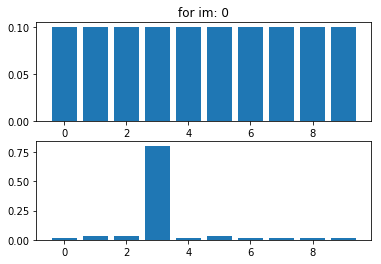


 dataset iteration 1
calculating prior!


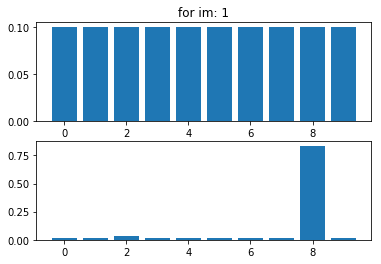


 dataset iteration 2
calculating prior!


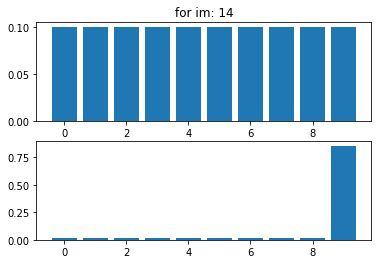


 dataset iteration 3
calculating prior!


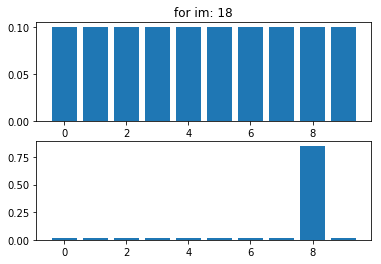


 dataset iteration 4
calculating prior!


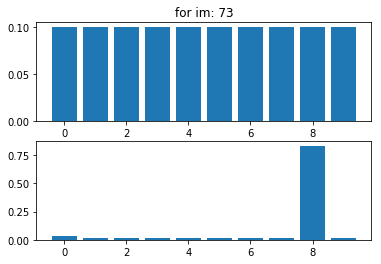


 dataset iteration 5
calculating prior!


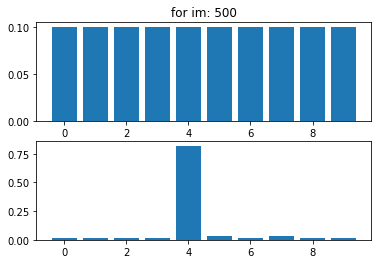


 dataset iteration 6
calculating prior!


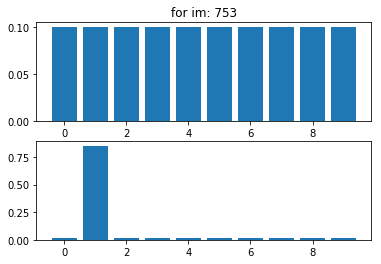


 dataset iteration 7
calculating prior!


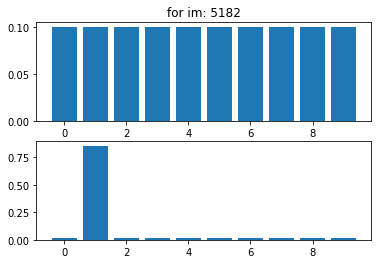


 dataset iteration 8
calculating prior!


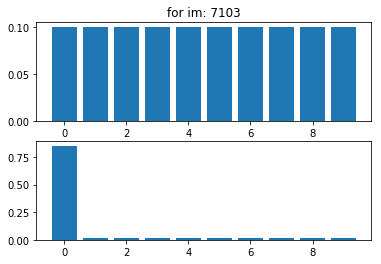


 dataset iteration 9
calculating prior!


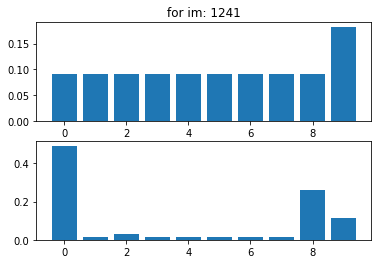


 dataset iteration 10
calculating prior!


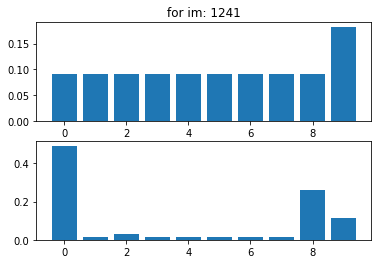


 dataset iteration 11
calculating prior!


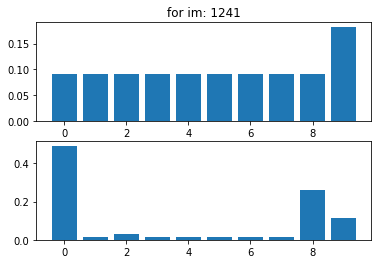


 dataset iteration 12
calculating prior!


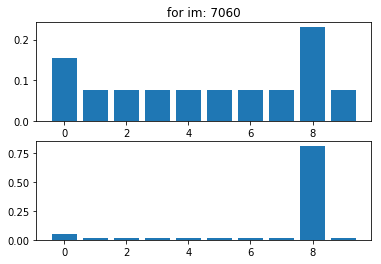


 dataset iteration 13
calculating prior!


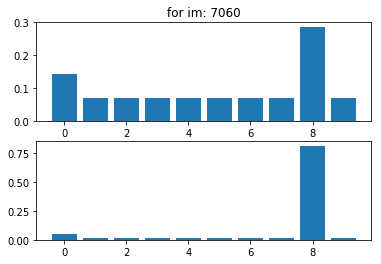


 dataset iteration 14
calculating prior!


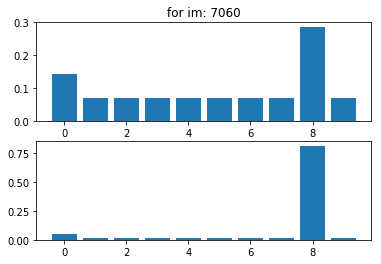


 dataset iteration 15
calculating prior!


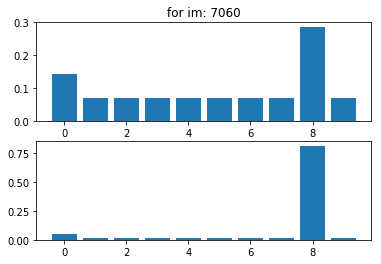


 dataset iteration 16
calculating prior!


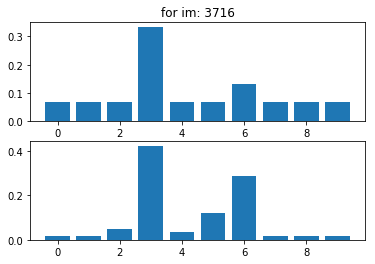


 dataset iteration 17
calculating prior!


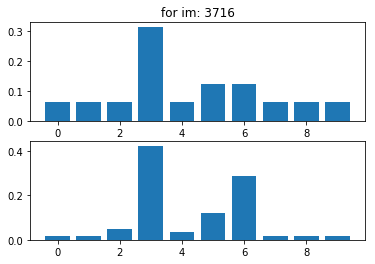


 dataset iteration 18
calculating prior!


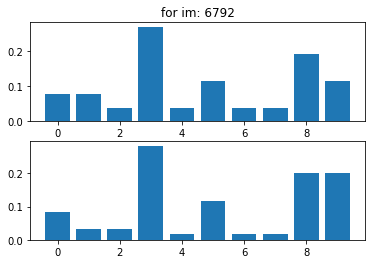


 dataset iteration 19
calculating prior!


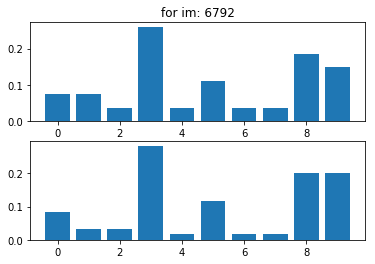


 dataset iteration 20
calculating prior!


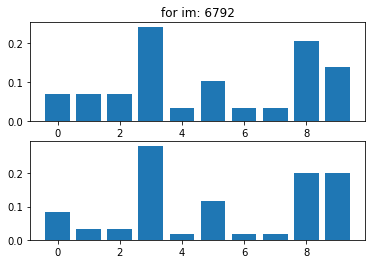


 dataset iteration 21
calculating prior!


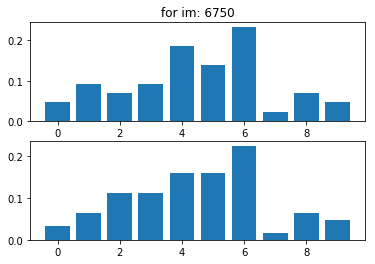


 dataset iteration 22
calculating prior!


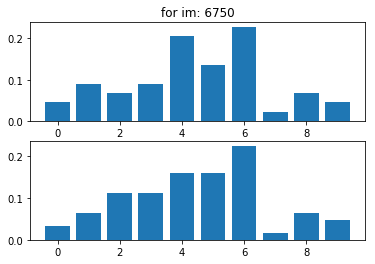


 dataset iteration 23
calculating prior!


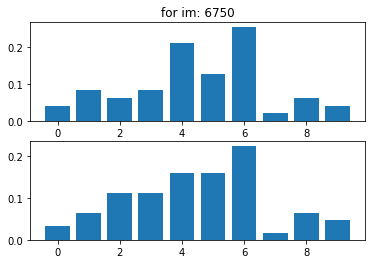


 dataset iteration 24
calculating prior!


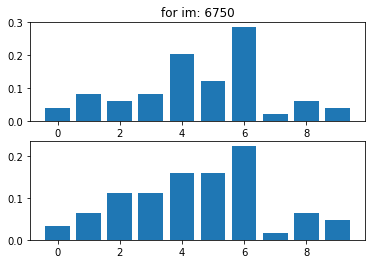


 dataset iteration 25
calculating prior!


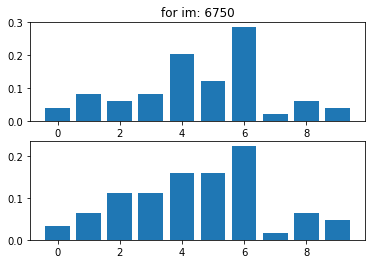


 dataset iteration 26
calculating prior!


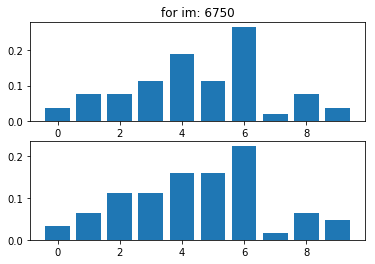


 dataset iteration 27
calculating prior!


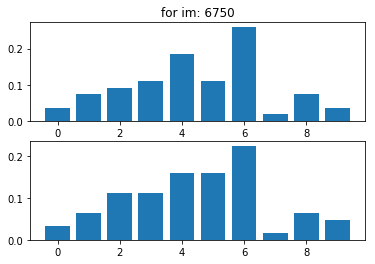


 dataset iteration 28
calculating prior!


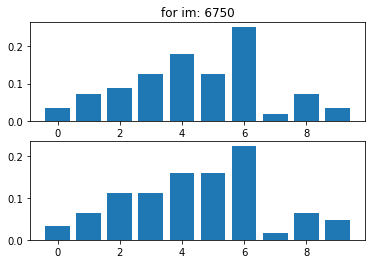


 dataset iteration 29
calculating prior!


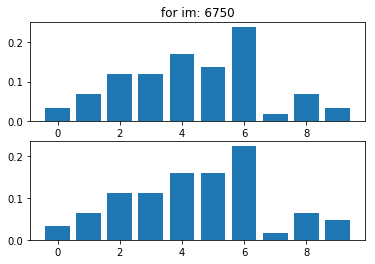


 dataset iteration 30
calculating prior!


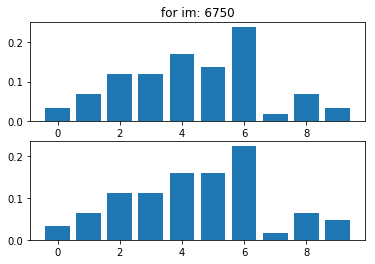


 dataset iteration 31
calculating prior!


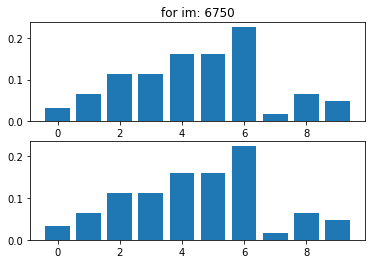

n samples carried: 1
carries detected!: 1

 dataset iteration 32
calculating prior!


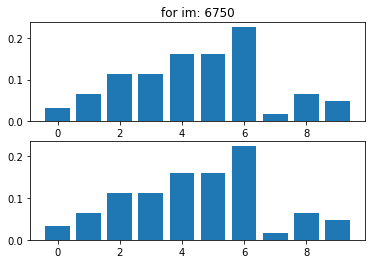

n samples carried: 3
carries detected!: 3

 dataset iteration 33
calculating prior!


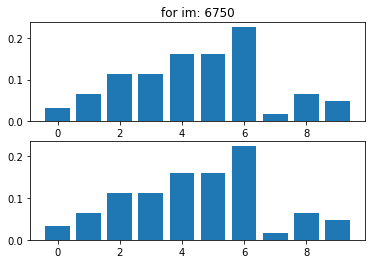

n samples carried: 12
carries detected!: 12

 dataset iteration 34
calculating prior!


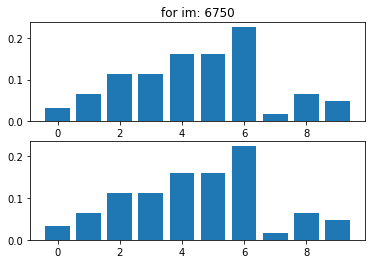

n samples carried: 10
carries detected!: 10

 dataset iteration 35
calculating prior!


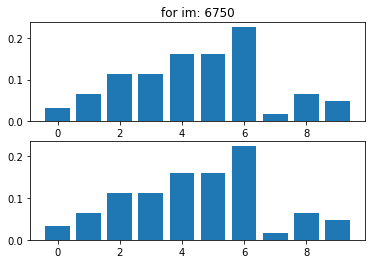

n samples carried: 16
carries detected!: 16

 dataset iteration 36
calculating prior!


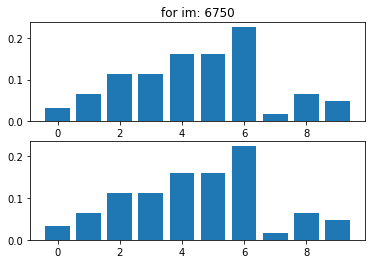

n samples carried: 28
carries detected!: 28

 dataset iteration 37
calculating prior!


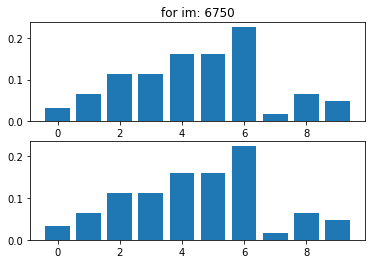

n samples carried: 38
carries detected!: 38

 dataset iteration 38
calculating prior!


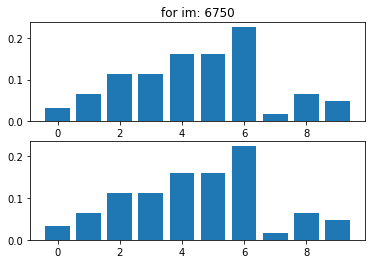

n samples carried: 46
carries detected!: 46

 dataset iteration 39
calculating prior!


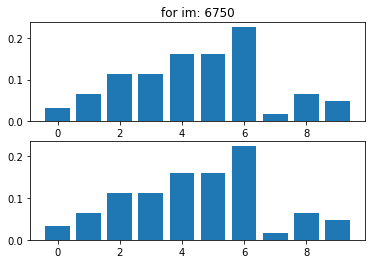

n samples carried: 68
carries detected!: 68

 dataset iteration 40
calculating prior!


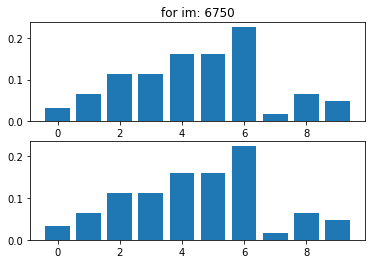

n samples carried: 78
carries detected!: 78

 dataset iteration 41
calculating prior!


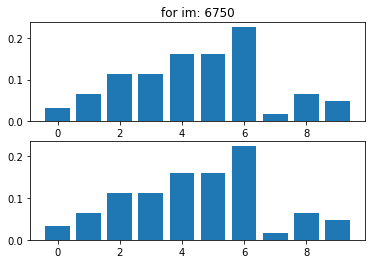

n samples carried: 93
carries detected!: 93

 dataset iteration 42
calculating prior!


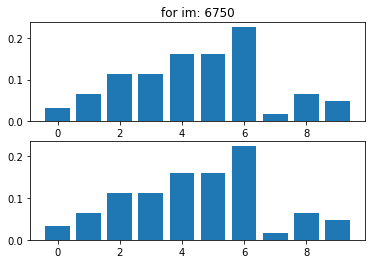

n samples carried: 141
carries detected!: 141
n samples carried: 1
carries detected!: 1

 dataset iteration 43
calculating prior!


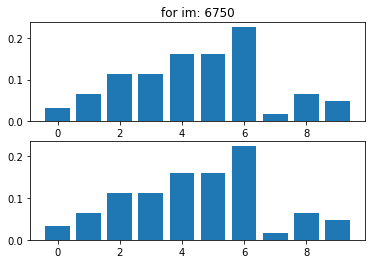

n samples carried: 208
carries detected!: 208

 dataset iteration 44
calculating prior!


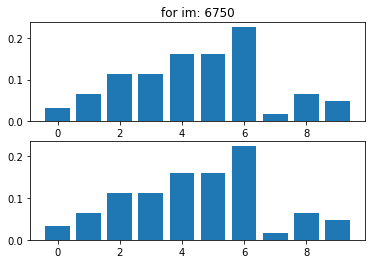

n samples carried: 287
carries detected!: 287

 dataset iteration 45
calculating prior!


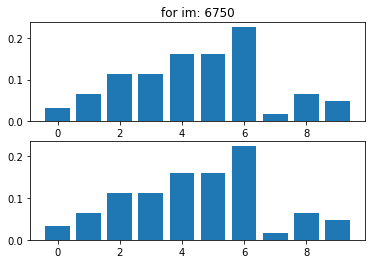

n samples carried: 330
carries detected!: 330

 dataset iteration 46
calculating prior!


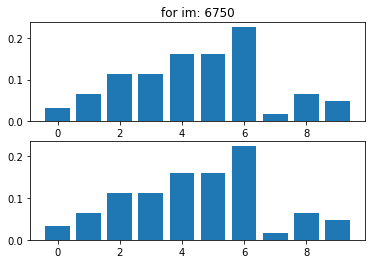

n samples carried: 474
carries detected!: 474
n samples carried: 4
carries detected!: 4

 dataset iteration 47
calculating prior!


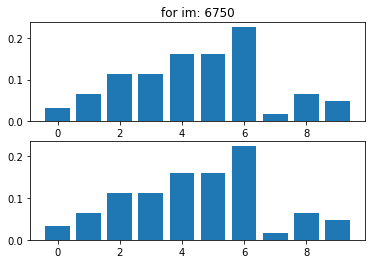

n samples carried: 704
carries detected!: 704
n samples carried: 8
carries detected!: 8

 dataset iteration 48
calculating prior!


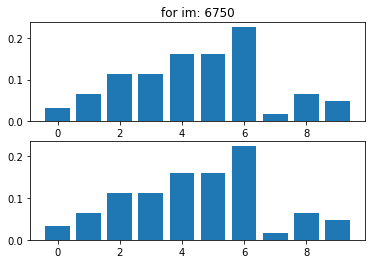

n samples carried: 1037
carries detected!: 1037
n samples carried: 12
carries detected!: 12

 dataset iteration 49
calculating prior!


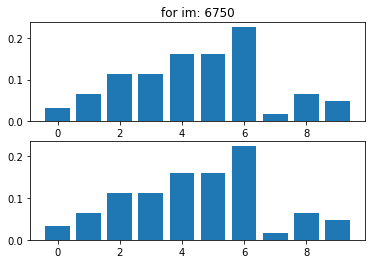

n samples carried: 1563
carries detected!: 1563
n samples carried: 69
carries detected!: 69
11000 500000 511000 511000


Text(0.5, 0, 'Number of samples (x 10,000)')

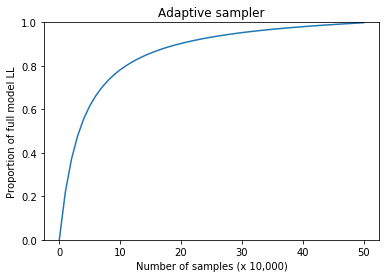

In [23]:
# uniform sampler
postRunCurrent, postRunRemainder, adaptiveScores = full_run(emptyModel.copy(), fullGuesses.copy(), 
                                                    flattenedPicNums, flattenedGuesses, prior_mode = 'adaptive')
adaptiveScores.insert(0, floorModel.LL)

postC = len(flatten_guesses(postRunCurrent)[0])
postR  = len(flatten_guesses(postRunRemainder)[0])

print(postR, postC, postR + postC, len(flattenedGuesses))


normalizedAdaptiveScores = (adaptiveScores - floorModel.LL) / (ceilingModel.LL - floorModel.LL)
plt.plot(normalizedAdaptiveScores)
plt.ylim([0, 1])
plt.title('Adaptive sampler')
plt.ylabel('Proportion of full model LL')
plt.xlabel('Number of samples (x 10,000)')
#plt.xticks(np.arange(len(scores)))


 dataset iteration 0

 dataset iteration 1

 dataset iteration 2

 dataset iteration 3

 dataset iteration 4

 dataset iteration 5

 dataset iteration 6

 dataset iteration 7

 dataset iteration 8

 dataset iteration 9

 dataset iteration 10

 dataset iteration 11

 dataset iteration 12

 dataset iteration 13

 dataset iteration 14

 dataset iteration 15

 dataset iteration 16

 dataset iteration 17

 dataset iteration 18

 dataset iteration 19

 dataset iteration 20

 dataset iteration 21

 dataset iteration 22

 dataset iteration 23

 dataset iteration 24

 dataset iteration 25

 dataset iteration 26

 dataset iteration 27

 dataset iteration 28
n samples carried: 2
carries detected!: 2

 dataset iteration 29

 dataset iteration 30
n samples carried: 3
carries detected!: 3

 dataset iteration 31

 dataset iteration 32
n samples carried: 3
carries detected!: 3

 dataset iteration 33
n samples carried: 2
carries detected!: 2

 dataset iteration 34
n samples carried: 12
carries detecte

Text(0.5, 0, 'Number of samples (x 10,000)')

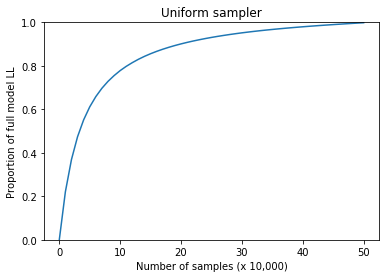

In [10]:
# uniform sampler
postRunCurrent, postRunRemainder, scores = full_run(emptyModel.copy(), fullGuesses.copy(), 
                                                    flattenedPicNums, flattenedGuesses)
scores.insert(0, floorModel.LL)

postC = len(flatten_guesses(postRunCurrent)[0])
postR  = len(flatten_guesses(postRunRemainder)[0])

print(postR, postC, postR + postC, len(flattenedGuesses))


normalizedScores = (scores - floorModel.LL) / (ceilingModel.LL - floorModel.LL)
plt.plot(normalizedScores, label = 'Uniform')
plt.ylim([0, 1])
plt.title('Uniform sampler')
plt.ylabel('Proportion of full model LL')
plt.xlabel('Number of samples (x 10,000)')
#plt.xticks(np.arange(len(scores)))

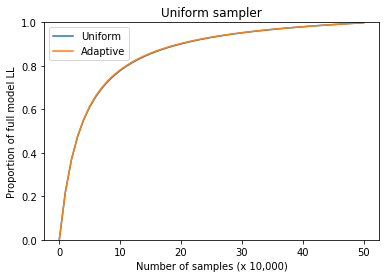

In [11]:
plt.plot(normalizedScores, label = 'Uniform')
plt.plot(normalizedAdaptiveScores, label = 'Adaptive')
plt.ylim([0, 1])
plt.title('Uniform sampler')
plt.ylabel('Proportion of full model LL')
plt.xlabel('Number of samples (x 10,000)')
plt.legend()